In [3]:
import numpy as np
import os
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import csv
import uncertainties as unc
from scipy.odr import *

# Inicialização dos Dados

In [4]:
# Path dos dados medidos

cwd = os.getcwd()
path_sem3 = os.path.join(cwd, "Sem3")

In [5]:
# Aderir dados
raw_data = pd.DataFrame()

sem3_files = os.listdir(path_sem3)
sem3_filepaths = [os.path.join(path_sem3, file) for file in sem3_files]

for i in range(0, len(sem3_files)):
    file = sem3_files[i]
    filepath = sem3_filepaths[i]
    
    # Ignorar arquivos que não sejam .csv
    if file[-4:] != ".csv":
        continue

    file_params = file.split("-")
    resolução = file_params[0]
    V_r = file_params[1].replace(',','.')
    temperatura = file_params[2].split(" ")[0].replace(',','.')
    
    iter_data = pd.read_csv(filepath, delimiter=';', usecols=[1,2])
    iter_data["Resolução"] = int(resolução) * 10e-9
    iter_data["V_r"] = float(V_r)
    iter_data["Temperatura"] = float(temperatura)
    raw_data = raw_data.append(iter_data)

## Funções

In [6]:
def f(B, x):
    '''Linear function y = m*x + b'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x + B[1]

## Algumas coisas

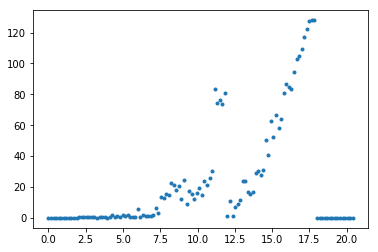

In [7]:
n = 2
z = raw_data['V(calib)'][258*n:258*n+120].tolist()
w = raw_data['i(canais)'][258*n:258*n+120].tolist()

plt.plot(z, w, '.')
plt.show()

In [8]:
#Um groupby que não deu muito certo
g = raw_data.groupby(['V(calib)','Temperatura']).mean()
sg = raw_data.groupby(['V(calib)','Temperatura']).std()

gt = g.groupby(level=0) #0=60.4 1 = 60.5
sgt = sg.groupby(level=0)

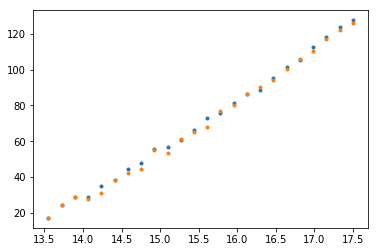

In [9]:
#então voltei pro formato mais fácil de array
X = gt.first().index.tolist()
y1 = gt.first()['i(canais)'].tolist()
y2 = gt.last()['i(canais)'].tolist()
sy1 = sgt.first()['i(canais)'].tolist()
sy2 = sgt.last()['i(canais)'].tolist()

X = np.array(X)
y1 = np.array(y1)
y2 = np.array(y2)
sy1 = np.array(sy1)
sy2 = np.array(sy2)

# upper and lower limits for linear fit
ll = 13.5
ul = 17.5
a = X>ll
b = X<ul
lp = np.multiply(a,b)

#new data for fit
ny1 = y1[lp]
ny2 = y2[lp]
nX = X[lp]
nsy1 = sy1[lp]
nsy2 = sy2[lp]

# Do you wanna see it?
#figure = plt.plot(X, y1, X, y2)
plt.plot(nX, ny1, '.', nX, ny2, '.')

Beta: [  27.83510879 -361.5821237 ]
Beta Std Error: [0.35768912 5.57675031]
Beta Covariance: [[  23.89571886 -371.47534886]
 [-371.47534886 5808.59409897]]
Residual Variance: 0.0053541603087812455
Inverse Condition #: 0.004616543649194154
Reason(s) for Halting:
  Sum of squares convergence
Beta: [  27.9600336  -364.69004656]
Beta Std Error: [0.43114226 6.72245069]
Beta Covariance: [[  24.3925602  -379.23784655]
 [-379.23784655 5930.22871252]]
Residual Variance: 0.007620505976007038
Inverse Condition #: 0.004592735285569363
Reason(s) for Halting:
  Sum of squares convergence


<ErrorbarContainer object of 3 artists>

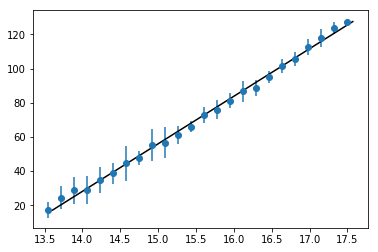

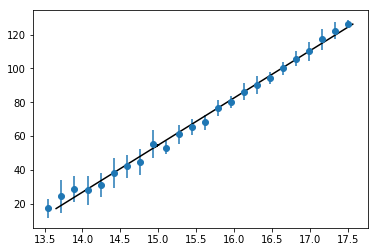

In [10]:
# Finalmete o ajuste
#60.4
linear = Model(f)
mydata = RealData(nX, ny1, sy=nsy1)
myodr = ODR(mydata, linear, beta0=[1., 2.])
R = myodr.run()
R.pprint()

fig, ax = plt.subplots()
ax.plot(R.xplus, R.y, 'black')
ax.errorbar(nX, ny1, yerr=nsy1, fmt='o')

# Finalmete o ajuste 2
#60.5
mydata2 = RealData(nX, ny2, sy=nsy2)
myodr2 = ODR(mydata2, linear, beta0=[1., 2.])
R2 = myodr2.run()
R2.pprint()

fig, ax = plt.subplots()
ax.plot(R2.xplus, R2.y, 'black')
ax.errorbar(nX, ny2, yerr=nsy2, fmt='o')

In [11]:
# Quantidades de interesse e devidas propagações de erro
# 60.4
a = R.beta[0]
b = R.beta[1]
sa = R.sd_beta[0]
sb = R.sd_beta[1]

v0 = -b/a
sv0 = np.sqrt( (sb/a)**2 + (b*sa/a/a)**2 )

# 60.5
a = R2.beta[0]
b = R2.beta[1]
sa = R2.sd_beta[0]
sb = R2.sd_beta[1]

v1 = -b/a
sv1 = np.sqrt( (sb/a)**2 + (b*sa/a/a)**2 )
v1 = v1-2.2
v0 = v0-2.2
sv1 = np.sqrt(sv1**2 + .2**2)
sv0 = np.sqrt(sv0**2 + .2**2)

v1, sv1, v0, sv0

(10.84326209895272,
 0.37183163338965297,
 10.790145877435634,
 0.3286405032273358)

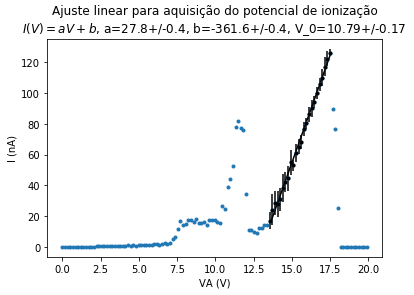

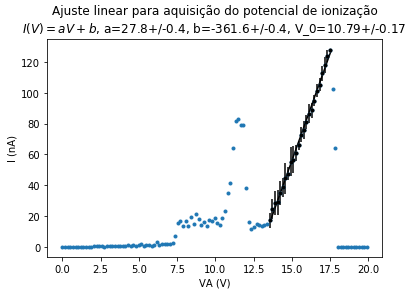

In [12]:
a = R.beta[0]
b = R.beta[1]
sa = R.sd_beta[0]
sb = R.sd_beta[1]
a = unc.ufloat(a, sa)
b = unc.ufloat(b, sa)
V0 = -b/a - 2.2
title_text = "Ajuste linear para aquisição do potencial de ionização"
title_text += "\n"
title_text += r"$I(V) = aV + b$, a={}, b={}, V_0={}".format(a, b, V0)

fig, ax = plt.subplots()
ax.plot(R2.xplus, R2.y, 'black', X[X<20], y2[X<20], '.')
ax.errorbar(nX, ny2, yerr=nsy2, fmt='.', color='black')
plt.xlabel('VA (V)')
plt.ylabel('I (nA)')
plt.title(title_text)
plt.show()

a = R.beta[0]
b = R.beta[1]
sa = R.sd_beta[0]
sb = R.sd_beta[1]
a = unc.ufloat(a, sa)
b = unc.ufloat(b, sa)
V0 = -b/a - 2.2
title_text = "Ajuste linear para aquisição do potencial de ionização"
title_text += "\n"
title_text += r"$I(V) = aV + b$, a={}, b={}, V_0={}".format(a, b, V0)

fig, ax = plt.subplots()
ax.plot(R.xplus, R.y, 'black', X[X<20], y1[X<20], '.')
ax.errorbar(nX, ny1, yerr=nsy1, fmt='.', color='black')
plt.xlabel('VA (V)')
plt.ylabel('I (nA)')
plt.title(title_text)
plt.show()

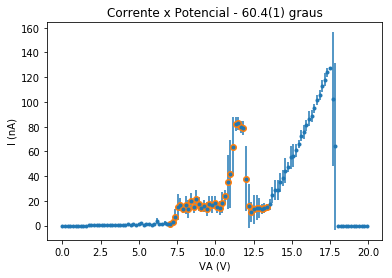

In [13]:
a = X<13.5
b = X>7
c = a*b


fig, ax = plt.subplots()
ax.errorbar(X[X<20], y1[X<20], yerr=sy1[X<20], fmt='.')
ax.plot(X[c], y1[c], 'o')


plt.xlabel('VA (V)')
plt.ylabel('I (nA)')
plt.title('Corrente x Potencial - 60.4(1) graus')
plt.savefig('Corrente x Potencial - 60.4(1) graus - região.png')

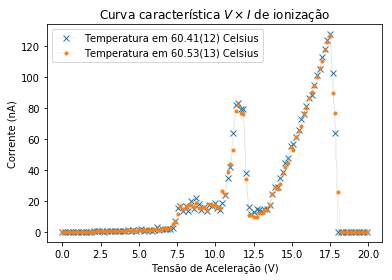

In [14]:
xx = X
yy1 = y1
yy2 = y2
inds = xx < 20
xx = xx[inds]
yy1 = yy1[inds]
yy2 = yy2[inds]
title_text = r"Curva característica $V \times I$ de ionização"

plt.plot(xx, yy1, 'x-', linewidth=0.1, label="Temperatura em 60.41(12) Celsius")
plt.plot(xx, yy2, '.-', linewidth=0.1, label="Temperatura em 60.53(13) Celsius")
plt.title(title_text)
plt.legend()
plt.ylabel("Corrente (nA)")
plt.xlabel("Tensão de Aceleração (V)")
plt.show()